In [153]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from glob import glob
import os
from os.path import join
import xarray as xr

import time
import copy 
import datetime

import sys  
sys.path.insert(0, '../')

from soundings.deep_learning import mlutilities as ml
from soundings.deep_learning import tf_neuralnetwork as nn
from soundings.preprocessing import preprocess

from soundings.plotting import radiosonde_plotting
from soundings.utils import radiosonde_utils

from IPython.display import display
from ipywidgets import FloatProgress

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

%load_ext autoreload
%autoreload 2

# vol = '/s/chopin/l/grad/stock/data/soundings/raobs/arm-sgp/'
vol = '/Users/stock/Development/research/soundings/data/raobs/arm-sgp/'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [16]:
xar = xr.open_dataset(vol + '2001/sgpsondewnpnC1.b1.20010401.112900.cdf')

p = xar.pres.values
t = xar.tdry.values
td = xar.dp.values

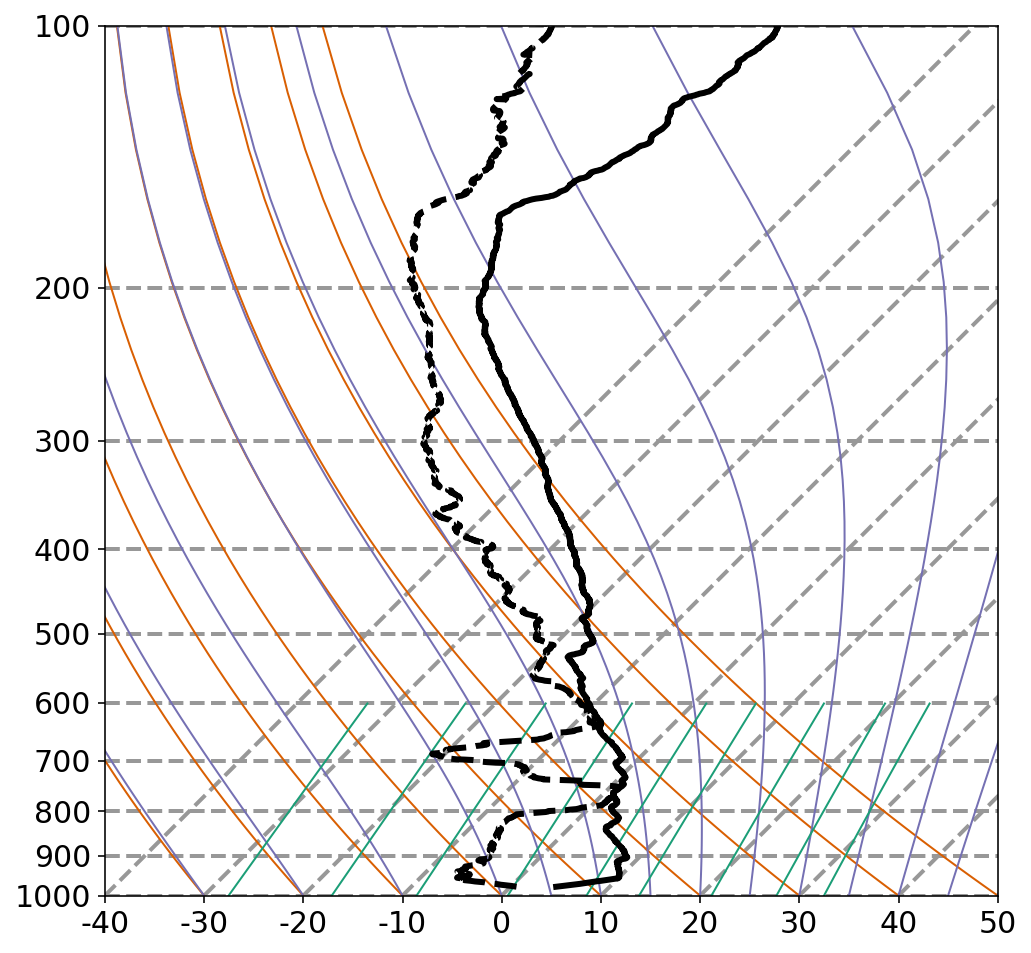

In [3]:
sounding_dict_for_metpy = dict()

sounding_dict_for_metpy[radiosonde_utils.PRESSURE_COLUMN_KEY] = p
sounding_dict_for_metpy[radiosonde_utils.TEMPERATURE_COLUMN_KEY] = t
sounding_dict_for_metpy[radiosonde_utils.DEWPOINT_COLUMN_KEY] = td

radiosonde_plotting.plot_sounding(sounding_dict_for_metpy)
plt.show()

In [3]:
SONDE_PROFILE_DIMS = 2000
PRESSURE = 0
TEMPERATURE = 1
DEWPOINT = 2

def valid_raob(xar):
    """Greater than N observations with all valid QC values
    """
    return (xar.time.values.size >= SONDE_PROFILE_DIMS and 
        all(np.unique(xar.qc_pres.values) == [0]) 
        and all(np.unique(xar.qc_tdry.values) == [0]) 
        and all(np.unique(xar.qc_dp.values) == [0]))

def plot_results(nnet, X, T, index=0):
    
    sounding_dict_for_metpy = dict()

    if len(X.shape) > 2:
        P = X[index,:,PRESSURE]
    else:
        P = X[index,:SONDE_PROFILE_DIMS]

    sounding_dict_for_metpy[radiosonde_utils.PRESSURE_COLUMN_KEY] = P
    sounding_dict_for_metpy[radiosonde_utils.TEMPERATURE_COLUMN_KEY] = T[index,:]
    sounding_dict_for_metpy[radiosonde_utils.PREDICTED_TEMPERATURE_COLUMN_KEY] = nnet.use(X[index:index+1,:])[0]

    radiosonde_plotting.plot_predicted_sounding(sounding_dict_for_metpy)
    
    fig, ax = plt.subplots(1, figsize=(8, 4))

    ax.plot(nnet.history['loss'], label='train')
    ax.plot(nnet.history['val_loss'], label='val')
    ax.legend();

time: 26.320, avg: 0.025 seconds
2001: 874/1037 are valid


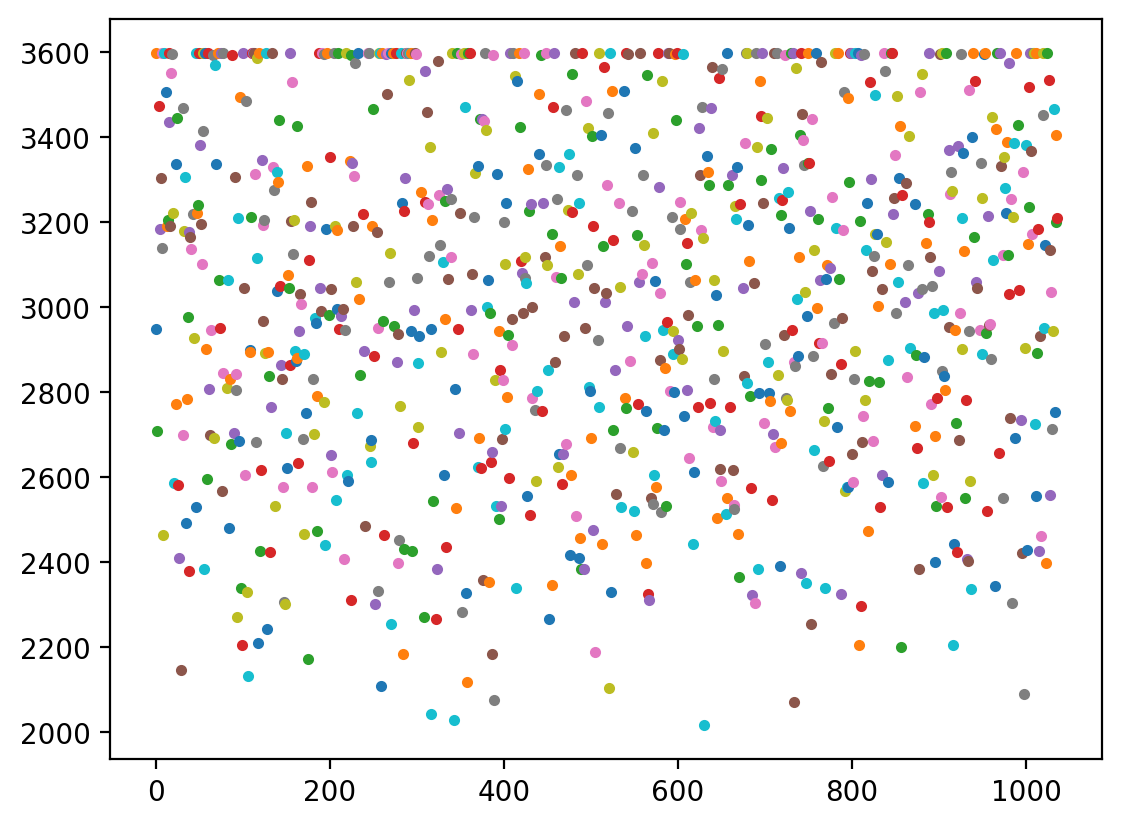

In [10]:
for year in range(2001, 2002): # 2021
    files = np.array(glob(join(vol, str(year), f'sgpsondewnpnC1.b1.*.cdf')))
    is_valid = np.ones(files.size, dtype=bool)
    s = time.time()
    for i, f in enumerate(files):
        xar = xr.open_dataset(f)
        if valid_raob(xar):
            plt.plot(i, xar.pres.values.size, '.')
        else:
            is_valid[i] = False
        xar.close()
    e = time.time() - s
    print(f'time: {e:.3f}, avg: {e/files.size:.3f} seconds')
    print(f'{year}: {np.where(is_valid == True)[0].size}/{files.size} are valid')

In [71]:
files = np.array(glob(join(vol, '*/sgpsondewnpnC1.b1.*.cdf')))

# Samples, (Pressure, Temperature, Dewpoint), Pressure Dims
profiles = np.zeros((files.size, 3, SONDE_PROFILE_DIMS))
is_valid = np.ones(files.size, dtype=bool)

s = time.time()
for i, f in enumerate(files):
    xar = xr.open_dataset(f)
    if valid_raob(xar):
        p = preprocess.interpolate_profile(xar.pres.values, SONDE_PROFILE_DIMS)
        t = preprocess.interpolate_profile(xar.tdry.values, SONDE_PROFILE_DIMS)
        td = preprocess.interpolate_profile(xar.dp.values, SONDE_PROFILE_DIMS)
        profiles[i] = np.concatenate(([p], [t], [td]))
    else:
        is_valid[i] = False        
    xar.close()    
e = time.time() - s

profiles = profiles[np.where(is_valid)[0]]

print(f'time: {e:.3f}, avg: {e/files.size:.3f} seconds')
print(f': {np.where(is_valid == True)[0].size}/{files.size} are valid')

time: 764.492, avg: 0.028 seconds
: 5605/27209 are valid


In [ ]:
np.save('/s/chopin/l/grad/stock/data/soundings/raobs/profiles.npy', profiles)

In [4]:
profiles = np.load(vol + '../profiles.npy')

In [5]:
profiles.shape

(24589, 3, 2000)

## Set GPU (Incompatible on CS)

In [10]:
gpus = tf.config.list_physical_devices('XLA_GPU')
if gpus:
    # Restrict TensorFlow to only use the first GPU
    try:
        tf.config.set_visible_devices(gpus[0], 'XLA_GPU')
        logical_gpus = tf.config.list_logical_devices('XLA_GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
    except RuntimeError as e:
        # Visible devices must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 0 Logical GPU


In [25]:
try:
    tf.config.experimental.set_memory_growth(gpus[0], True)
    assert tf.config.experimental.get_memory_growth(physical_devices[0])
except:
    # Invalid device or cannot modify virtual devices once initialized.
    pass

In [11]:
!nvidia-smi

Fri Jul 10 11:29:37 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 440.82       CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX TIT...  Off  | 00000000:03:00.0 Off |                  N/A |
| 32%   72C    P2    75W / 250W |   1029MiB / 12212MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

## Fully Connected NN

In [19]:
Xtrain, Ttrain, Xtest, Ttest = ml.partition(profiles, profiles, (0.8,0.2), shuffle=True)

input_dims = [PRESSURE, TEMPERATURE, DEWPOINT]

Xtrain = Xtrain[:, input_dims, :]
Xtrain = Xtrain.reshape((-1, Xtrain[0,:].size))
Ttrain = Ttrain[:, TEMPERATURE, :]

Xtest = Xtest[:, input_dims, :]
Xtest = Xtest.reshape((-1, Xtest[0,:].size))
Ttest = Ttest[:, TEMPERATURE, :]
    
Xtrain.shape, Ttrain.shape, Xtest.shape, Ttest.shape

((19671, 6000), (19671, 2000), (4918, 6000), (4918, 2000))

In [28]:
# 176 s
nnet = nn.NeuralNetwork(Xtrain.shape[1], [512, 256, 128, 256, 512], Ttrain.shape[1], activation='relu')
nnet.train(Xtrain, Ttrain, 25, 64, method='adam', verbose=True, 
           learning_rate=0.005, validation=[Xtest, Ttest])

epoch: 0, loss: 0.21868
epoch: 5, loss: 0.08301
epoch: 10, loss: 0.07301
epoch: 15, loss: 0.06841
epoch: 20, loss: 0.06474
epoch: 24, loss: 0.06029
finished!


NeuralNetwork(6000, [512, 256, 128, 256, 512], 2000)
  Final objective value is 0.06029 in 117.1774 seconds.

In [56]:
nnet.model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 6000)]            0         
_________________________________________________________________
dense (Dense)                (None, 512)               3072512   
_________________________________________________________________
batch_normalization (BatchNo (None, 512)               2048      
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_2 (Dense)              (None, 128)               32896     
_________________________________________________________________
batch_normalization_1 (Batch (None, 128)               512       
_________________________________________________________________
dense_3 (Dense)              (None, 256)               33024 

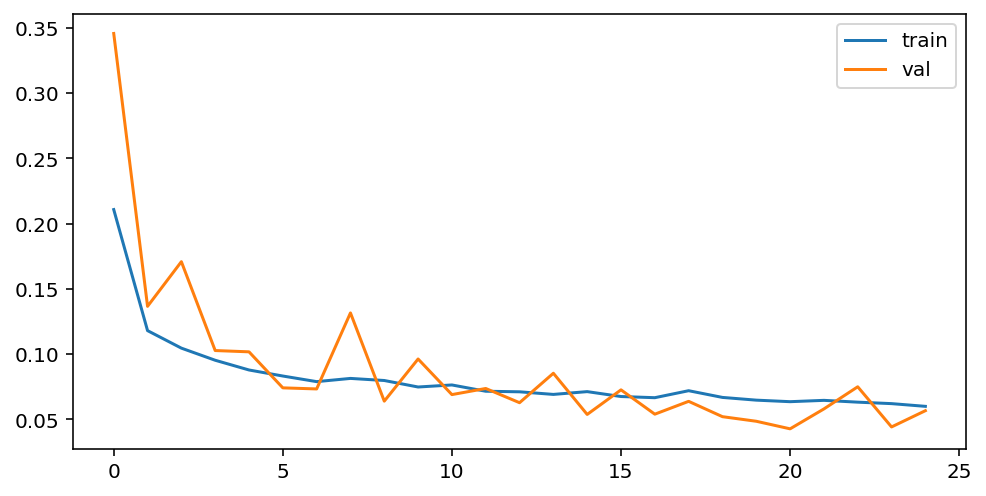

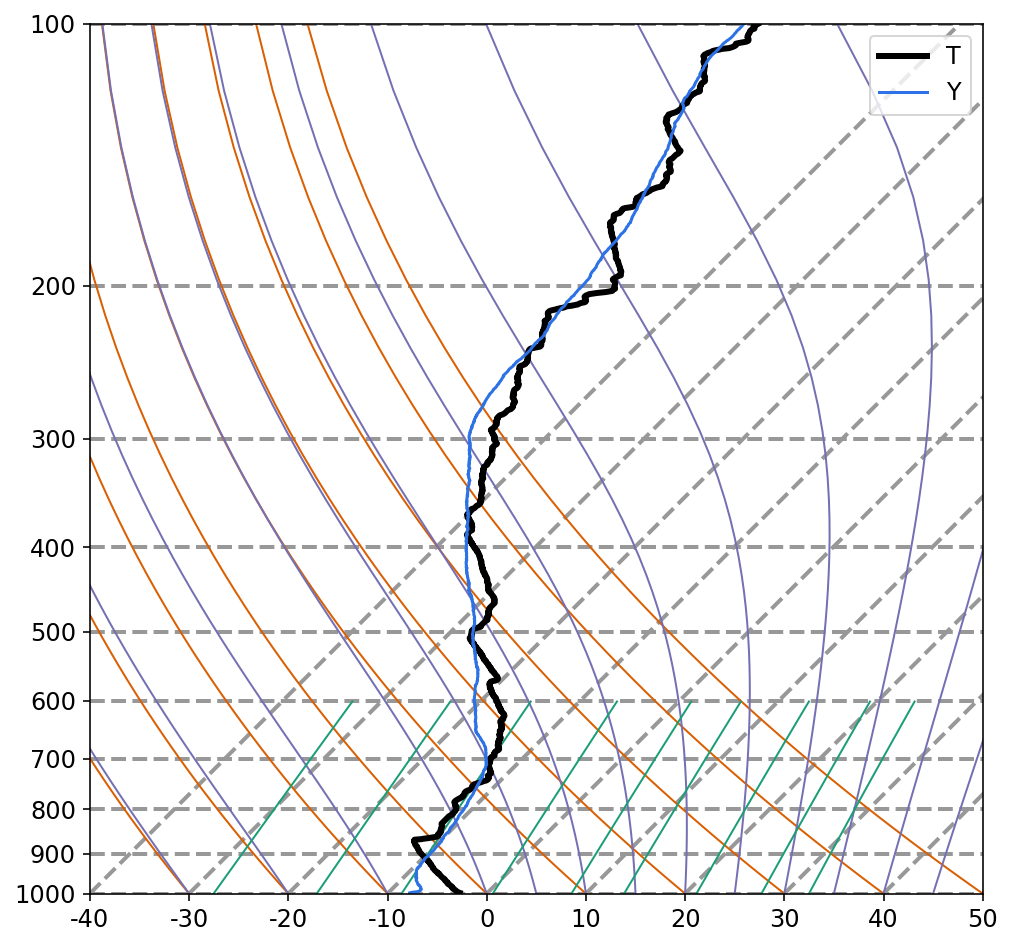

In [71]:
plot_results(nnet, Xtest, Ttest, index=0)

## Convolutional NN

In [6]:
Xtrain, Ttrain, Xtest, Ttest = ml.partition(profiles, profiles, (0.8,0.2), shuffle=False)

input_dims = [PRESSURE, TEMPERATURE, DEWPOINT]

Xtrain = np.swapaxes(Xtrain[:, input_dims, :], 1, 2)
Ttrain = Ttrain[:, TEMPERATURE, :]

Xtest = np.swapaxes(Xtest[:, input_dims, :], 1, 2)
Ttest = Ttest[:, TEMPERATURE, :]
    
Xtrain.shape, Ttrain.shape, Xtest.shape, Ttest.shape

((19671, 2000, 3), (19671, 2000), (4918, 2000, 3), (4918, 2000))

In [28]:
from tensorflow.python.keras import backend as K
from tensorflow.python.ops import math_ops
from tensorflow.python.framework import ops

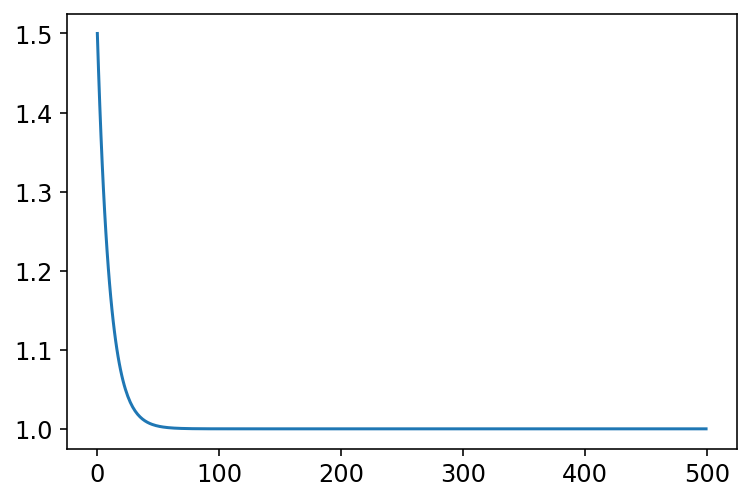

In [112]:
x = np.arange(2000)
y = lambda x: 0.5 * np.exp(-.1 * x) + 1
plt.plot(y(x)[:500]);

In [113]:
def weighted_mean_squared_error(y_true, y_pred):
    y_pred = ops.convert_to_tensor_v2(y_pred)
    y_true = math_ops.cast(y_true, y_pred.dtype)
    diff = math_ops.squared_difference(y_pred, y_true)
    
    x = np.arange(diff.shape[1])
    y = lambda x: 0.5 * np.exp(-.1 * x) + 1
    diff *= y(x)
    
    return K.mean(diff, axis=-1)

In [134]:
nnet._standardizeT(Ttrain).min()

-5.8555630681603805

In [136]:
nnet = nn.ConvolutionalNeuralNetwork(Xtrain.shape[1:], [3]*4, [(10, 1)]*4,
                                     Ttrain.shape[1], activation='relu')
nnet.train(Xtrain, Ttrain, 20, 256, method='adam', verbose=True, 
           learning_rate=0.001, validation=[Xtest, Ttest], loss_f=weighted_mean_squared_error)

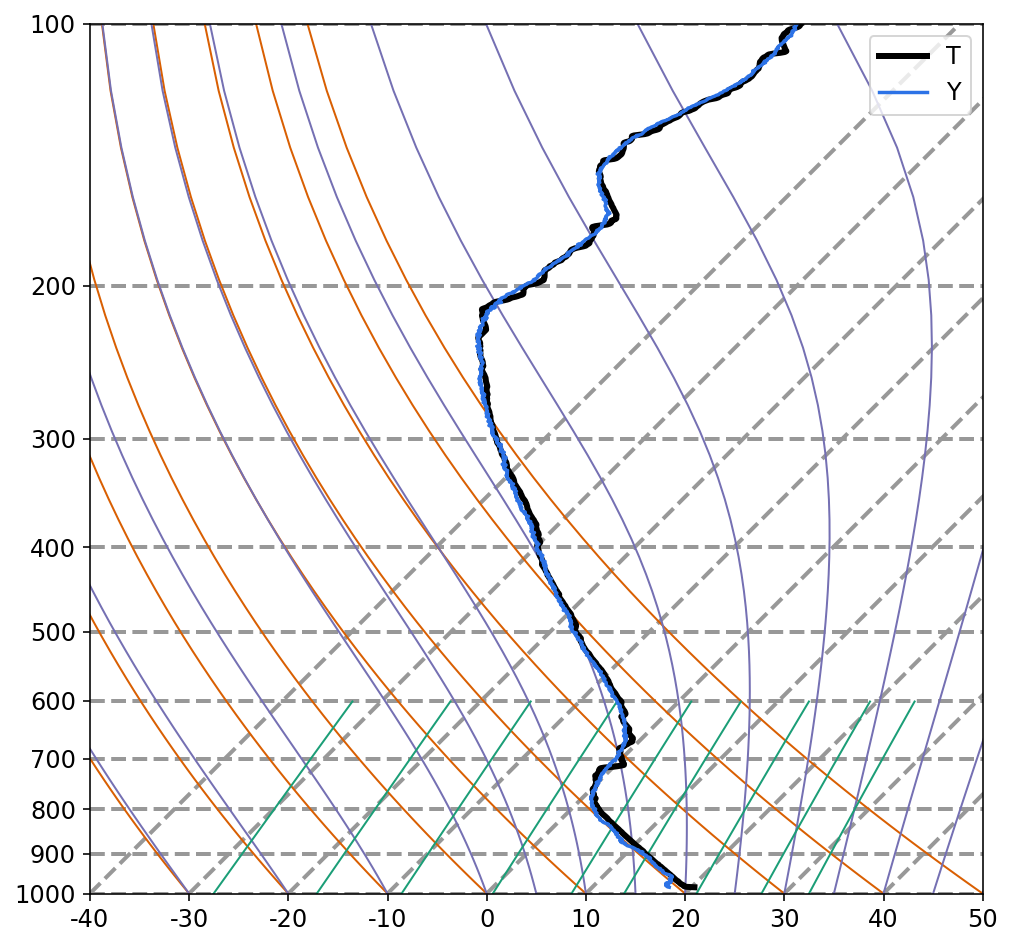

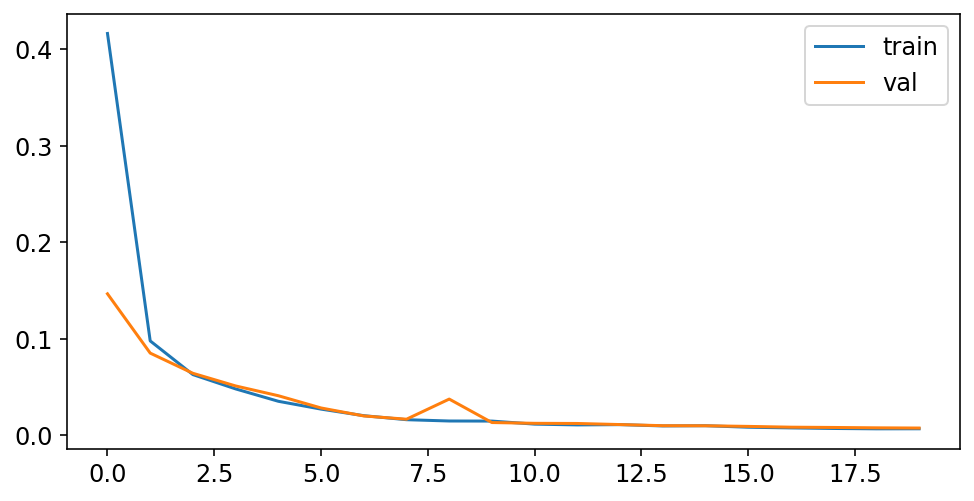

In [129]:
plot_results(nnet, Xtest, Ttest, index=22)

In [130]:
mean_error, bins = mean_pressure_errors(nnet, Xtest, Ttest)

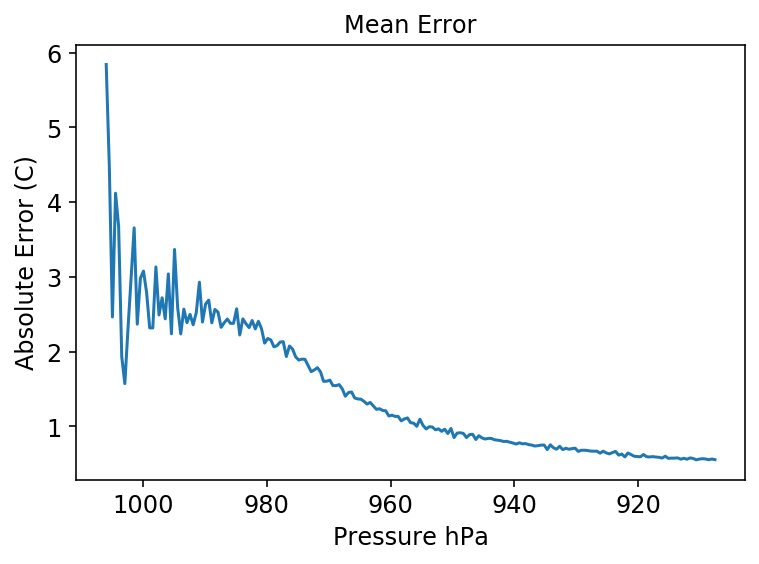

In [131]:
plt.plot(bins[1800:], mean_error[1800:])
plt.gca().invert_xaxis()
plt.xlabel('Pressure hPa')
plt.ylabel('Absolute Error (C)')
plt.title('Mean Error');
plt.show();

In [36]:
nnet = nn.ConvolutionalNeuralNetwork(Xtrain.shape[1:], [3]*4, [(10, 1)]*4,
                                     Ttrain.shape[1], activation='relu')
nnet.train(Xtrain, Ttrain, 10, 128, method='adam', verbose=True, 
           learning_rate=0.001, validation=[Xtest, Ttest])

epoch: 0, loss: 0.28404
epoch: 5, loss: 0.02126
epoch: 9, loss: 0.01366
finished!


ConvolutionalNeuralNetwork((2000, 3), [3, 3, 3, 3], [(10, 1), (10, 1), (10, 1), (10, 1)], 2000)
  Final objective value is 0.01366 in 84.5748 seconds.

In [49]:
nnet.model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 2000, 3)]         0         
_________________________________________________________________
conv1d (Conv1D)              (None, 2000, 2)           62        
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 1000, 2)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 1000, 4)           84        
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 500, 4)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 500, 8)            328       
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 250, 8)            0     

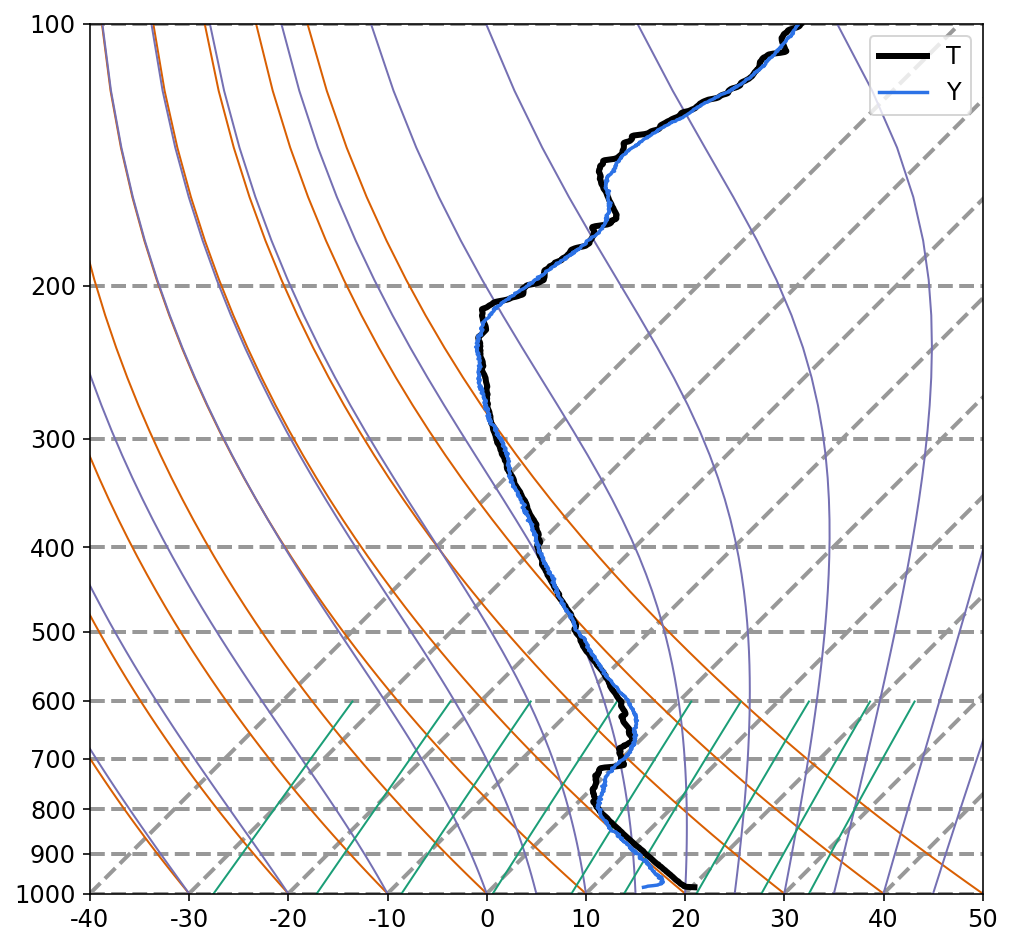

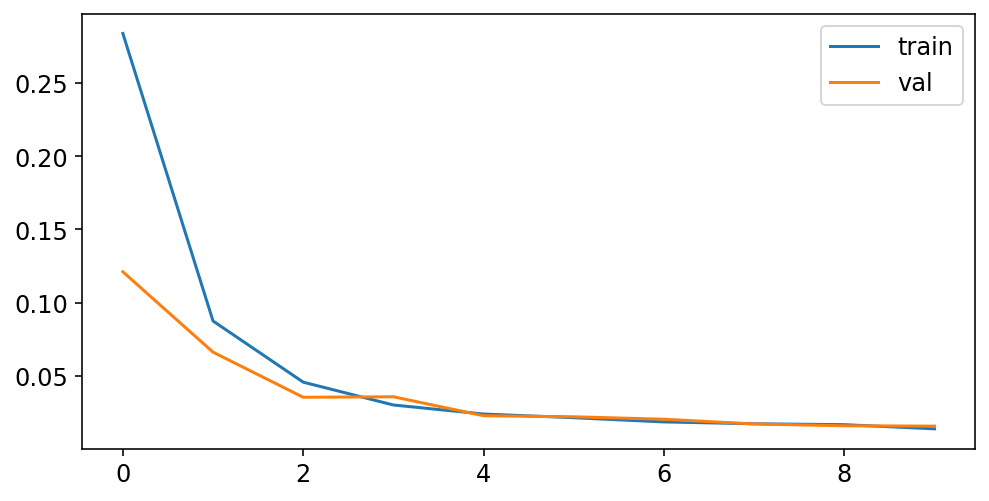

In [37]:
plot_results(nnet, Xtest, Ttest, index=22)

In [38]:
mean_error, bins = mean_pressure_errors(nnet, Xtest, Ttest)

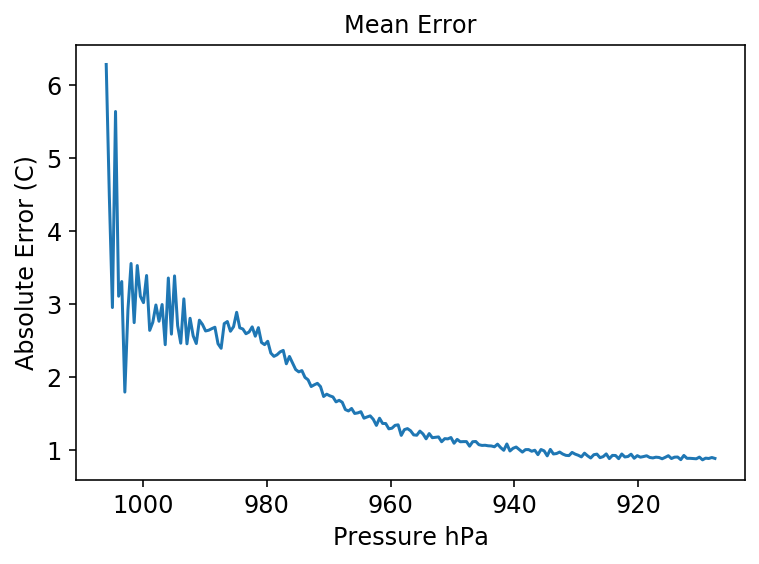

In [39]:
plt.plot(bins[1800:], mean_error[1800:])
plt.gca().invert_xaxis()
plt.xlabel('Pressure hPa')
plt.ylabel('Absolute Error (C)')
plt.title('Mean Error');
plt.show();

In [ ]:
epochs = 10
batch_size = 128 #, 64
rho = 0.001
activation = ['relu']
depth = 3
units = [[nu] * nl for nu in [1, 3, 5, 10] for nl in range(1, depth + 1)] # 
ker_str = [[nu] * nl for nu in [(10, 1)] for nl in range(1, depth + 1)] # , (20, 1)
trials = len(units)

methods = ['adam']

f = FloatProgress(min=0, max=(trials * len(activations)))
display(f)

fig, axs = plt.subplots(len(methods), 1, figsize=(14, 7 * len(methods)))
for m, method in enumerate(methods):
    loss = []
    ax = axs if len(methods) == 1 else axs[m]
    for i in range(trials):
        n_units_in_conv_layers = units[i]
        
        kernels_size_and_stride = ker_str[len(n_units_in_conv_layers)-1]
        
        nnet = nn.ConvolutionalNeuralNetwork(Xtrain.shape[1:], n_units_in_conv_layers, 
                                             kernels_size_and_stride,
                                             Ttrain.shape[1], activation=activation)
        nnet.train(Xtrain, Ttrain, epochs, batch_size, method=method, verbose=False, 
                   learning_rate=rho, validation=[Xtest, Ttest])
        
        loss.append(nnet.history['val_loss'])
        f.value += 1
    
    color=iter(plt.cm.rainbow(np.linspace(0,1,trials)))

    for j, err in enumerate(loss):
        ax.plot(err, c=next(color), label='Network '+str(units[j]))

    ax.set_title(method)
    ax.set_xlabel('epoch'), plt.ylabel('Standardized RMSE')
    ax.legend(); ax.grid(True);

plt.show()

FloatProgress(value=0.0, max=12.0)

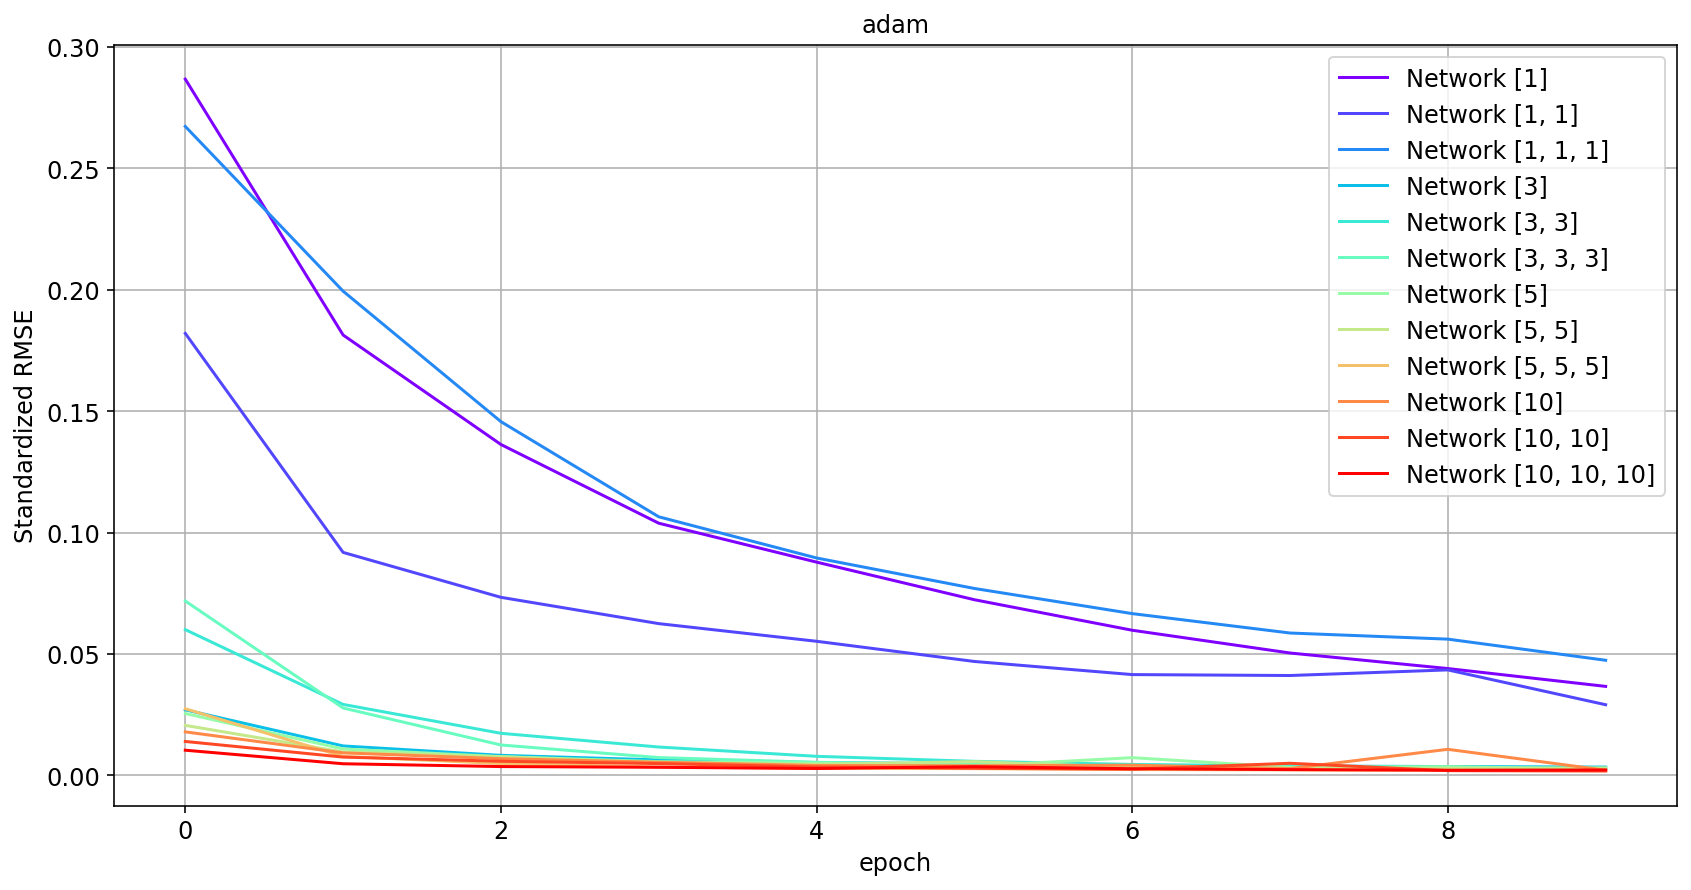

In [48]:
epochs = 10
batch_size = 128 #, 64
rho = 0.001
activation = 'relu'
depth = 3
units = [[nu] * nl for nu in [1, 3, 5, 10] for nl in range(1, depth + 1)] # 
ker_str = [[nu] * nl for nu in [(10, 1)] for nl in range(1, depth + 1)] # , (20, 1)
trials = len(units)

methods = ['adam']

f = FloatProgress(min=0, max=(trials * len(methods)))
display(f)

fig, axs = plt.subplots(len(methods), 1, figsize=(14, 7 * len(methods)))
for m, method in enumerate(methods):
    loss = []
    ax = axs if len(methods) == 1 else axs[m]
    for i in range(trials):
        n_units_in_conv_layers = units[i]
        
        kernels_size_and_stride = ker_str[len(n_units_in_conv_layers)-1]
        
        nnet = nn.ConvolutionalNeuralNetwork(Xtrain.shape[1:], n_units_in_conv_layers, 
                                             kernels_size_and_stride,
                                             Ttrain.shape[1], activation=activation)
        nnet.train(Xtrain, Ttrain, epochs, batch_size, method=method, verbose=False, 
                   learning_rate=rho, validation=[Xtest, Ttest])
        
        loss.append(nnet.history['val_loss'])
        f.value += 1
    
    color=iter(plt.cm.rainbow(np.linspace(0,1,trials)))

    for j, err in enumerate(loss):
        ax.plot(err, c=next(color), label='Network '+str(units[j]))

    ax.set_title(method)
    ax.set_xlabel('epoch'), plt.ylabel('Standardized RMSE')
    ax.legend(); ax.grid(True);

plt.show()

In [56]:
# min rmse
np.min(nnet.history['val_loss'])

0.0020879118237644434

In [19]:
tf.keras.losses.MSE(Ttest[0:1,:], nnet.use(Xtest[0:1,:]))

<tf.Tensor: shape=(1,), dtype=float64, numpy=array([20.68639338])>

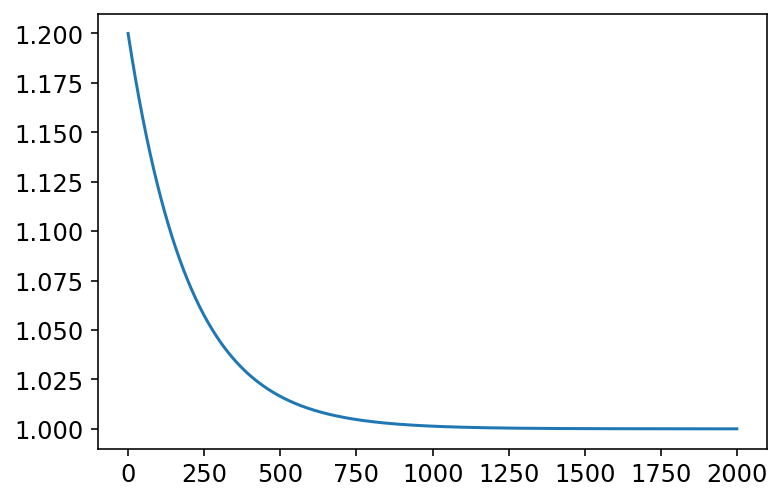

In [98]:
# exponential decay

plt.plot(y(x))

In [20]:
%timeit weighted_mean_squared_error(Ttest[0:1,:], nnet.use(Xtest[0:1,:]))

16.8 ms ± 312 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [ ]:
np.square(np.log(Ttest[0:1,:] + 1) - np.log(nnet.use(Xtest[0:1,:]) + 1))

In [54]:
nnet.model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 2000, 3)]         0         
_________________________________________________________________
conv1d (Conv1D)              (None, 2000, 10)          310       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 1000, 10)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 1000, 10)          1010      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 500, 10)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 500, 10)           1010      
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 250, 10)           0     

## Error Evaluation

In [33]:
def mean_pressure_errors(nnet, X, T):
    error = np.abs((nnet.use(X) - T))
    pressures = Xtest[:,:,PRESSURE]
    # Create linearly spaced bins from the min to max 
    bins = np.linspace(pressures.min(), pressures.max(), SONDE_PROFILE_DIMS)
    # Indicies of where which bin pressure values belong
    pressure_bin_indicies = np.digitize(pressures, bins)
    pressure_bin_indicies
    
    mean_error = np.zeros(bins.size)
    # Mean error corresponding to each bin of pressure levels
    for bin_index in range(bins.size):
        vals = error[pressure_bin_indicies == bin_index]
        mean = np.mean(vals) if vals.size > 0 else 0
        mean_error[bin_index] = mean
        
    # trim mean 0's from ends
    s = 0
    for i in range(mean_error.size):
        if mean_error[i] != 0:
            s = i
            break
    e = mean_error.size
    for i in range(mean_error.size-1, 0, -1):
        if mean_error[i] != 0:
            e = i
            break

    mean_error = mean_error[s:e+1]
    bins = bins[s:e+1]
    
    return mean_error, bins

## Convolutional AutoEncoder

In [145]:
Xtrain, Ttrain, Xtest, Ttest = ml.partition(profiles, profiles, (0.8,0.2), shuffle=False)

input_dims = [PRESSURE, TEMPERATURE, DEWPOINT]

Xtrain = np.swapaxes(Xtrain[:, input_dims, :], 1, 2)
Ttrain = Ttrain[:, TEMPERATURE, :]

Xtest = np.swapaxes(Xtest[:, input_dims, :], 1, 2)
Ttest = Ttest[:, TEMPERATURE, :]
    
Xtrain.shape, Ttrain.shape, Xtest.shape, Ttest.shape

((19671, 2000, 3), (19671, 2000), (4918, 2000, 3), (4918, 2000))

In [147]:
nnet = nn.ConvolutionalAutoEncoder(Xtrain.shape[1:], [3, 3, 3], [(10, 1)]*3,
                                     Ttrain.shape[1], activation='relu')
# nnet.model.summary()
nnet.train(Xtrain, Ttrain, 10, 64, method='adam', verbose=True, 
           learning_rate=0.001, validation=[Xtest, Ttest])

epoch: 0, loss: 0.25888
epoch: 5, loss: 0.01078
epoch: 9, loss: 0.00780
finished!


ConvolutionalAutoEncoder((2000, 3), [3, 3, 3], [(10, 1), (10, 1), (10, 1)], 2000)
  Final objective value is 0.00780 in 188.3591 seconds.

In [148]:
nnet.model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 2000, 3)]         0         
_________________________________________________________________
conv1d (Conv1D)              (None, 2000, 3)           93        
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 1000, 3)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 1000, 3)           93        
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 500, 3)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 500, 3)            93        
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 250, 3)            0     

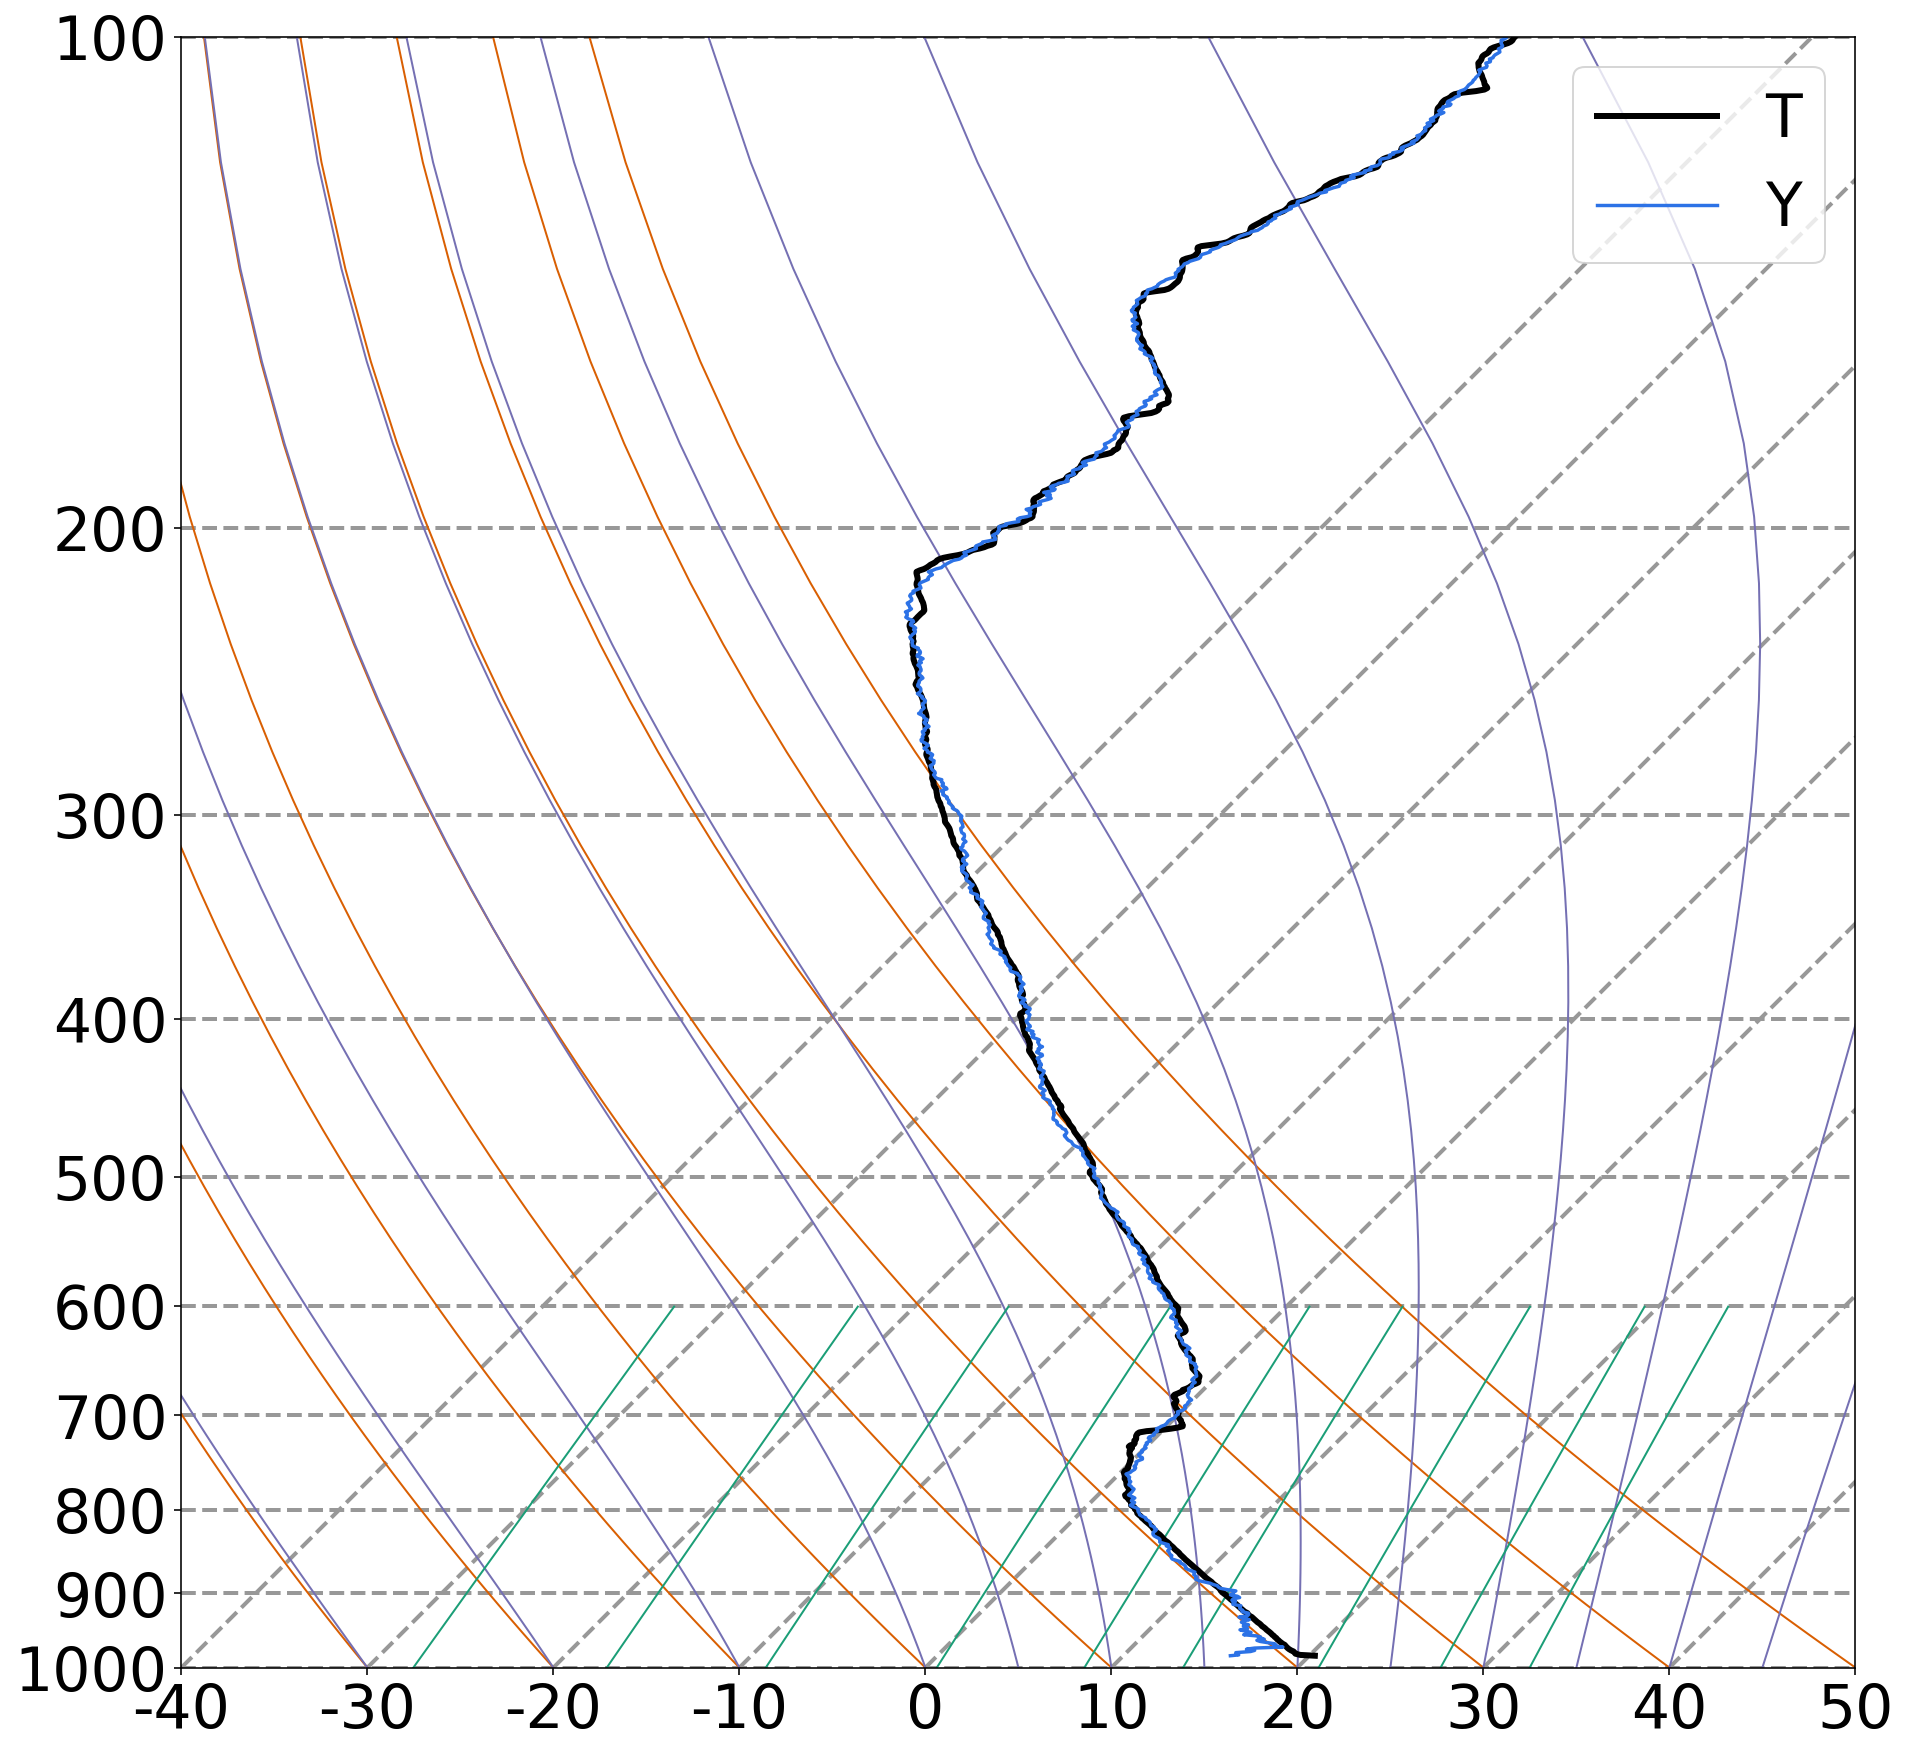

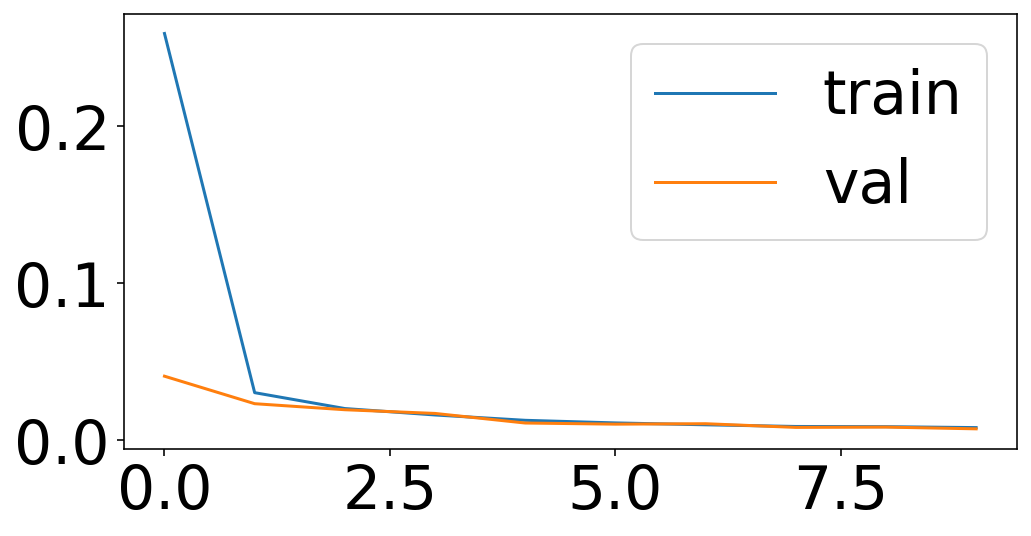

In [152]:
plot_results(nnet, Xtest, Ttest, index=22)

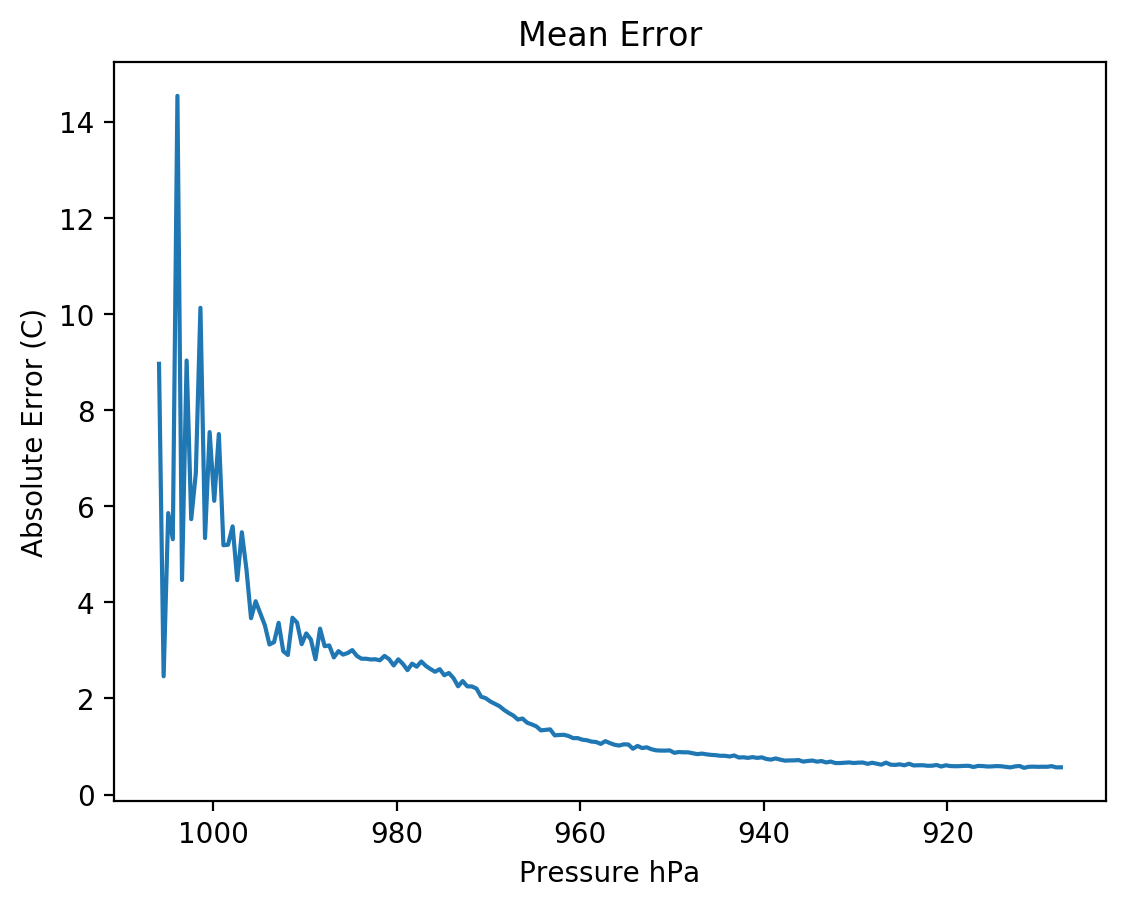

In [155]:
mean_error, bins = mean_pressure_errors(nnet, Xtest, Ttest)
plt.rcdefaults()
plt.plot(bins[1800:], mean_error[1800:])
plt.gca().invert_xaxis()
plt.xlabel('Pressure hPa')
plt.ylabel('Absolute Error (C)')
plt.title('Mean Error');
plt.show();

## Operational

In [77]:
def sizeof_fmt(num, suffix='B'):
    ''' by Fred Cirera,  https://stackoverflow.com/a/1094933/1870254, modified'''
    for unit in ['','Ki','Mi','Gi','Ti','Pi','Ei','Zi']:
        if abs(num) < 1024.0:
            return "%3.1f %s%s" % (num, unit, suffix)
        num /= 1024.0
    return "%.1f %s%s" % (num, 'Yi', suffix)

for name, size in sorted(((name, sys.getsizeof(value)) for name, value in locals().items()),
                         key= lambda x: -x[1])[:10]:
    print("{:>30}: {:>8}".format(name, sizeof_fmt(size)))

                      profiles:  1.1 GiB
                         files: 10.9 MiB
                      is_valid: 26.7 KiB
                 FloatProgress:  1.0 KiB
                           _i8:  926.0 B
                          _i24:  815.0 B
                          _i27:  810.0 B
                          _i29:  807.0 B
                          _i30:  807.0 B
                          _i32:  798.0 B


## Density

In [142]:
files = np.array(glob(join(vol, '2001/sgpsondewnpnC1.b1.*.cdf')))

pressures = np.array([])

s = time.time()
for i, f in enumerate(files):
    xar = xr.open_dataset(f)
    if valid_raob(xar):
        pressures = np.append(pressures, xar.pres.values)    
    xar.close()    
e = time.time() - s

print(f'time: {e:.3f}, avg: {e/files.size:.3f} seconds')

time: 11.227, avg: 0.011 seconds


In [143]:
pressures.shape

(2647636,)

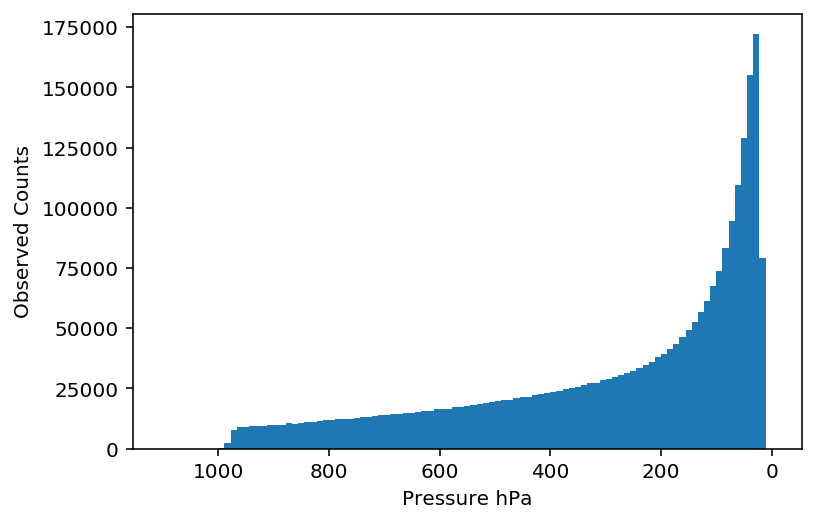

In [154]:
plt.hist(pressures, bins=np.linspace(0, 1100, 100))
plt.gca().invert_xaxis()
plt.xlabel('Pressure hPa')
plt.ylabel('Observed Counts');

In [161]:
Xtrain[:,:,PRESSURE].ravel().shape

(39342000,)

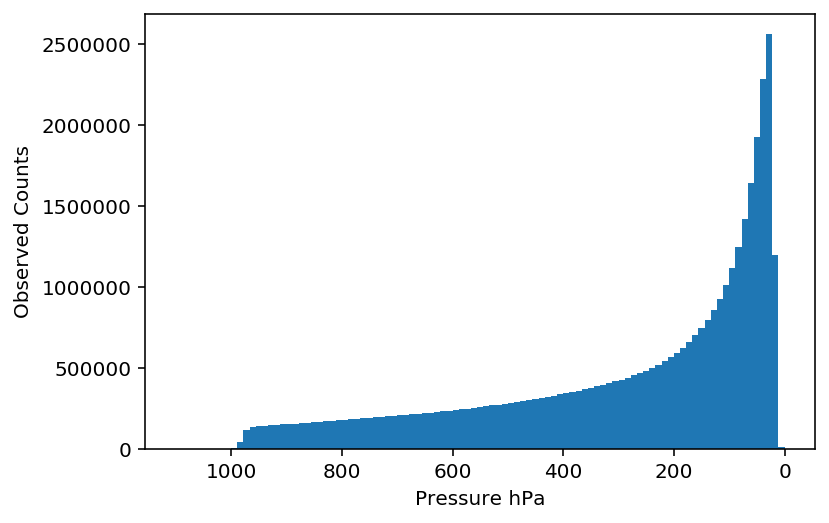

In [160]:
plt.hist(Xtrain[:,:,PRESSURE].ravel(), bins=np.linspace(0, 1100, 100))
plt.gca().invert_xaxis()
plt.xlabel('Pressure hPa')
plt.ylabel('Observed Counts');